## Imports

In [1]:
import os
import tarfile
import urllib
from scipy import stats

import pandas as pd
from pandas import DataFrame, Series
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

# Data
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

## Data Loading

In [2]:
df = pd.read_csv("../../datasets/raw/bone_marrow_raw.csv")
df.convert_dtypes()

,donor_age,donor_age_below_35,donor_ABO,donor_CMV,recipient_age,recipient_age_below_10,recipient_age_int,recipient_gender,recipient_body_mass,recipient_ABO,...,CD3_to_CD34_ratio,ANC_recovery,PLT_recovery,acute_GvHD_II_III_IV,acute_GvHD_III_IV,time_to_acute_GvHD_III_IV,extensive_chronic_GvHD,relapse,survival_time,survival_status
0,22.830137,yes,A,present,9.6,yes,5_10,male,35.0,A,...,1.33876,19,51,yes,yes,32,no,no,999,0
1,23.342466,yes,B,absent,4.0,yes,0_5,male,20.6,B,...,11.078295,16,37,yes,no,1000000,no,yes,163,1
2,26.394521,yes,B,absent,6.6,yes,5_10,male,23.4,B,...,19.01323,23,20,yes,no,1000000,no,yes,435,1
3,39.684932,no,A,present,18.1,no,10_20,female,50.0,AB,...,29.481647,23,29,yes,yes,19,?,no,53,1
4,33.358904,yes,A,absent,1.3,yes,0_5,female,9.0,AB,...,3.972255,14,14,no,no,1000000,no,no,2043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,37.575342,no,A,present,12.9,no,10_20,male,44.0,A,...,2.52275,15,22,yes,yes,16,no,yes,385,1
183,22.89589,yes,A,absent,13.9,no,10_20,female,44.5,0,...,1.038858,12,30,no,no,1000000,no,no,634,1
184,27.347945,yes,A,present,10.4,no,10_20,female,33.0,B,...,1.635559,16,16,yes,no,1000000,no,no,1895,0
185,27.780822,yes,A,absent,8.0,yes,5_10,male,24.0,0,...,8.07777,13,14,yes,yes,54,yes,no,382,1


## Data Manipulation

- Remove unwanted features
- Rename attributes
- Reorder attributes

In [3]:
df.columns

Index(['donor_age', 'donor_age_below_35', 'donor_ABO', 'donor_CMV',
       'recipient_age', 'recipient_age_below_10', 'recipient_age_int',
       'recipient_gender', 'recipient_body_mass', 'recipient_ABO',
       'recipient_rh', 'recipient_CMV', 'disease', 'disease_group',
       'gender_match', 'ABO_match', 'CMV_status', 'HLA_match', 'HLA_mismatch',
       'antigen', 'allel', 'HLA_group_1', 'risk_group', 'stem_cell_source',
       'tx_post_relapse', 'CD34_x1e6_per_kg', 'CD3_x1e8_per_kg',
       'CD3_to_CD34_ratio', 'ANC_recovery', 'PLT_recovery',
       'acute_GvHD_II_III_IV', 'acute_GvHD_III_IV',
       'time_to_acute_GvHD_III_IV', 'extensive_chronic_GvHD', 'relapse',
       'survival_time', 'survival_status'],
      dtype='object')

<Axes: >

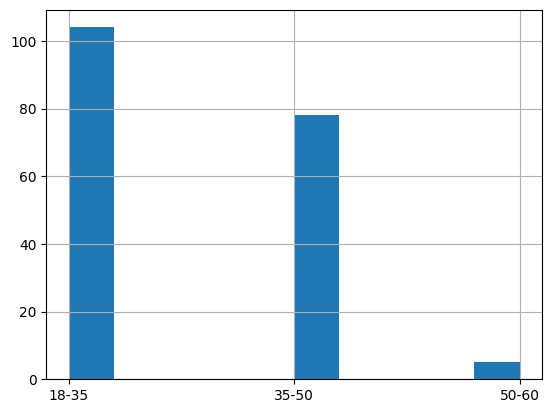

In [4]:
df["donor_age_group"] = pd.cut(df["donor_age"], bins=[18., 35., 50., 60.], labels=["18-35", "35-50", "50-60"])
df["donor_age_group"].hist()

In [5]:
df = df.drop(columns=["survival_time", "survival_status",
                      "recipient_age_int", "recipient_rh", "HLA_group_1", "ANC_recovery", "PLT_recovery",
                      "acute_GvHD_II_III_IV", "acute_GvHD_III_IV", "time_to_acute_GvHD_III_IV", "extensive_chronic_GvHD"])

df.columns

Index(['donor_age', 'donor_age_below_35', 'donor_ABO', 'donor_CMV',
       'recipient_age', 'recipient_age_below_10', 'recipient_gender',
       'recipient_body_mass', 'recipient_ABO', 'recipient_CMV', 'disease',
       'disease_group', 'gender_match', 'ABO_match', 'CMV_status', 'HLA_match',
       'HLA_mismatch', 'antigen', 'allel', 'risk_group', 'stem_cell_source',
       'tx_post_relapse', 'CD34_x1e6_per_kg', 'CD3_x1e8_per_kg',
       'CD3_to_CD34_ratio', 'relapse', 'donor_age_group'],
      dtype='object')

In [6]:
df.rename(columns={"allel": "allels_incompatible",
                   "antigen": "antigens_incompatible",
                   "HLA_match": "HLA_score",
                   "HLA_mismatch": "HLA_match",
                   "CMV_status": "CMV_serostatus",
                   "CD34_x1e6_per_kg": "CD34_per_kg", 
                   "CD3_x1e8_per_kg": "CD3_per_kg",
                   "CD3_to_CD34_ratio": "CD3_CD34_ratio",
                   "tx_post_relapse": "transplant_repeat",
                   "disease_group": "malignant_disease"}, inplace=True)

df.columns

Index(['donor_age', 'donor_age_below_35', 'donor_ABO', 'donor_CMV',
       'recipient_age', 'recipient_age_below_10', 'recipient_gender',
       'recipient_body_mass', 'recipient_ABO', 'recipient_CMV', 'disease',
       'malignant_disease', 'gender_match', 'ABO_match', 'CMV_serostatus',
       'HLA_score', 'HLA_match', 'antigens_incompatible',
       'allels_incompatible', 'risk_group', 'stem_cell_source',
       'transplant_repeat', 'CD34_per_kg', 'CD3_per_kg', 'CD3_CD34_ratio',
       'relapse', 'donor_age_group'],
      dtype='object')

In [7]:
df = df.loc[:, ["donor_age_group", "donor_age", "donor_age_below_35", "donor_CMV", "donor_ABO",
                 "recipient_age", "recipient_age_below_10", "recipient_CMV", "recipient_ABO", "recipient_gender", "recipient_body_mass",
                 "disease", "malignant_disease",
                 "CMV_serostatus", "ABO_match", "gender_match", "HLA_score", "HLA_match", "antigens_incompatible", "allels_incompatible",
                 "risk_group", "stem_cell_source", "transplant_repeat",
                 "CD34_per_kg", "CD3_per_kg", "CD3_CD34_ratio",
                 "relapse"]]

In [8]:
df

,donor_age_group,donor_age,donor_age_below_35,donor_CMV,donor_ABO,recipient_age,recipient_age_below_10,recipient_CMV,recipient_ABO,recipient_gender,...,HLA_match,antigens_incompatible,allels_incompatible,risk_group,stem_cell_source,transplant_repeat,CD34_per_kg,CD3_per_kg,CD3_CD34_ratio,relapse
0,18-35,22.830137,yes,present,A,9.6,yes,present,A,male,...,matched,0,0,high,peripheral_blood,no,7.20,5.38,1.338760,no
1,18-35,23.342466,yes,absent,B,4.0,yes,absent,B,male,...,matched,0,0,low,bone_marrow,no,4.50,0.41,11.078295,yes
2,18-35,26.394521,yes,absent,B,6.6,yes,present,B,male,...,matched,0,0,low,bone_marrow,no,7.94,0.42,19.013230,yes
3,35-50,39.684932,no,present,A,18.1,no,absent,AB,female,...,matched,0,0,low,bone_marrow,no,4.25,0.14,29.481647,no
4,18-35,33.358904,yes,absent,A,1.3,yes,present,AB,female,...,matched,2,1,high,peripheral_blood,no,51.85,13.05,3.972255,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,35-50,37.575342,no,present,A,12.9,no,present,A,male,...,matched,0,0,high,peripheral_blood,yes,11.08,4.39,2.522750,yes
183,18-35,22.895890,yes,absent,A,13.9,no,present,0,female,...,matched,0,0,high,peripheral_blood,no,4.64,4.47,1.038858,no
184,18-35,27.347945,yes,present,A,10.4,no,present,B,female,...,matched,0,0,low,peripheral_blood,no,7.73,4.73,1.635559,no
185,18-35,27.780822,yes,absent,A,8.0,yes,absent,0,male,...,matched,2,1,low,peripheral_blood,no,15.41,1.91,8.077770,no


## TT Split

- Split data using relapse strata


In [9]:
split = StratifiedShuffleSplit(1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["relapse"]):
    train_set: DataFrame = df.loc[train_index]
    test_set: DataFrame = df.loc[test_index]

In [10]:
data = train_set.drop(labels=["relapse"], axis=1)
data_label = train_set["relapse"].map({"no": 0, "yes": 1})

## Data Preparation Pipeline

- Remove duplicates
- Handle missing values
- Encode features

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149 entries, 12 to 14
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   donor_age_group         149 non-null    category
 1   donor_age               149 non-null    float64 
 2   donor_age_below_35      149 non-null    object  
 3   donor_CMV               149 non-null    object  
 4   donor_ABO               149 non-null    object  
 5   recipient_age           149 non-null    float64 
 6   recipient_age_below_10  149 non-null    object  
 7   recipient_CMV           149 non-null    object  
 8   recipient_ABO           149 non-null    object  
 9   recipient_gender        149 non-null    object  
 10  recipient_body_mass     148 non-null    float64 
 11  disease                 149 non-null    object  
 12  malignant_disease       149 non-null    object  
 13  CMV_serostatus          149 non-null    object  
 14  ABO_match               149 non

Get column type arrays

In [12]:
bool_attribs = ["donor_CMV", "recipient_age_below_10", "recipient_CMV", "recipient_gender", "malignant_disease", "ABO_match",
                "gender_match", "HLA_match", "risk_group", "stem_cell_source", "transplant_repeat", "relapse"]

onehot_attribs = ["donor_ABO", "recipient_ABO", "disease"]

ordinal_attribs = ["donor_age_group", "HLA_score"]

num_attribs = ["recipient_age", "recipient_body_mass", "antigens_incompatible",
               "allels_incompatible", "CD34_per_kg", "CD3_per_kg", "CD3_CD34_ratio"]

Fill body mass, CD ratio and CD3/34 per kg

In [13]:
data.columns[data.isna().any()]

Index(['recipient_body_mass', 'CD3_per_kg', 'CD3_CD34_ratio'], dtype='object')

<Axes: xlabel='CD34_per_kg', ylabel='CD3_per_kg'>

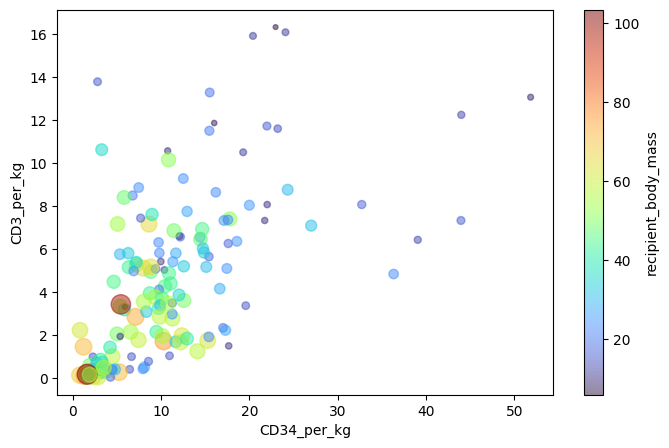

In [14]:
visualization_data = train_set.copy()

visualization_data["risk_group"] = visualization_data["risk_group"].map({"high": 1, "low": 0})

visualization_data.plot(kind="scatter", x="CD34_per_kg", y="CD3_per_kg", c="recipient_body_mass", s=data["recipient_body_mass"]*2,
           cmap=plt.get_cmap("turbo"), colorbar=True, alpha=0.5, figsize=(8, 5))

In [15]:
visualization_data[visualization_data["CD3_CD34_ratio"] > 40]

,donor_age_group,donor_age,donor_age_below_35,donor_CMV,donor_ABO,recipient_age,recipient_age_below_10,recipient_CMV,recipient_ABO,recipient_gender,...,HLA_match,antigens_incompatible,allels_incompatible,risk_group,stem_cell_source,transplant_repeat,CD34_per_kg,CD3_per_kg,CD3_CD34_ratio,relapse
117,35-50,43.065753,no,absent,B,6.7,yes,present,0,female,...,matched,0,0,0,bone_marrow,no,4.27,0.04,99.560970,no
136,18-35,34.624658,yes,present,0,14.7,no,absent,B,male,...,matched,0,0,0,bone_marrow,no,2.88,0.05,56.065024,yes
65,35-50,45.915068,no,absent,0,14.2,no,present,A,female,...,matched,2,1,0,bone_marrow,no,2.34,0.05,47.869839,no


In [16]:
missing_body_mass = float(visualization_data["recipient_body_mass"].where(
    visualization_data["CD34_per_kg"] > 29.1).where(
        visualization_data["CD34_per_kg"] < 39.1).median())

In [17]:
missing_CD3_CD34_ratio = float(visualization_data["CD3_CD34_ratio"].where(
    visualization_data["CD34_per_kg"] > 29.1).where(
        visualization_data["CD34_per_kg"] < 39.1).median())

In [18]:
# imputed_CD3 = rows_nan["CD34_per_kg"].values[0] / missing_CD3_CD34_ratio
# imputed_CD3

Handle CMV values

In [19]:
data.columns[(data.astype(str) == "?").any()]

Index(['donor_CMV', 'recipient_CMV', 'recipient_ABO', 'CMV_serostatus',
       'ABO_match'],
      dtype='object')

In [20]:
def encode_booleans(data: DataFrame):
    zero_mapper = {"absent", "no", "female", "mismatched", "female_to_male", "low", "nonmalignant", "peripheral_blood", "?"}
    one_mapper  = {"present", "yes", "male", "matched", "other", "high", "malignant", "bone_marrow"}

    def map_values(value):
        if value in zero_mapper:
            return 0
        if value in one_mapper:
            return 1
        
        return value

    return data.map(map_values)

In [21]:
visualization_data[bool_attribs] = encode_booleans(visualization_data[bool_attribs])

In [22]:
visualization_data["donor_CMV"].unique()

array([1, 0], dtype=int64)

In [23]:
len(visualization_data[visualization_data["donor_CMV"] == "?"]["donor_CMV"])

0

In [24]:
len(visualization_data[visualization_data["recipient_CMV"] == "?"]["recipient_CMV"])

0

In [25]:
len(visualization_data[visualization_data["CMV_serostatus"] == "?"]["CMV_serostatus"])

14

In [26]:
visualization_data[visualization_data["CMV_serostatus"] == "?"]

,donor_age_group,donor_age,donor_age_below_35,donor_CMV,donor_ABO,recipient_age,recipient_age_below_10,recipient_CMV,recipient_ABO,recipient_gender,...,HLA_match,antigens_incompatible,allels_incompatible,risk_group,stem_cell_source,transplant_repeat,CD34_per_kg,CD3_per_kg,CD3_CD34_ratio,relapse
129,35-50,40.317808,no,0,0,17.7,0,0,?,1,...,1,0,0,1,0,0,4.49,1.00,4.468419,0
27,35-50,39.983562,no,0,A,4.7,1,0,B,1,...,0,2,3,0,0,0,11.27,3.48,3.242425,0
18,35-50,43.375342,no,0,0,0.6,1,0,A,0,...,1,0,0,0,0,0,22.97,16.31,1.408646,0
43,18-35,20.358904,yes,1,0,9.9,1,0,B,1,...,1,0,0,0,1,0,5.33,5.75,0.927108,0
30,18-35,24.731507,yes,0,A,8.6,1,0,B,0,...,1,2,1,0,0,0,9.78,4.11,2.380569,0
6,18-35,34.520548,yes,0,0,14.4,0,0,A,0,...,1,0,0,0,0,0,17.78,7.39,2.406248,0
93,18-35,22.408219,yes,1,0,7.6,1,0,A,0,...,1,0,0,0,0,0,11.65,1.68,6.928599,0
112,18-35,28.268493,yes,1,0,5.4,1,0,A,0,...,1,1,2,1,0,0,15.51,13.27,1.168705,0
103,18-35,33.915068,yes,0,A,9.5,1,0,0,0,...,1,2,1,1,0,1,36.34,4.83,7.517388,0
147,18-35,25.772603,yes,0,A,18.2,0,0,A,0,...,1,0,0,0,0,0,6.55,2.14,3.065758,0


array([[<Axes: xlabel='recipient_age', ylabel='recipient_age'>,
        <Axes: xlabel='recipient_body_mass', ylabel='recipient_age'>,
        <Axes: xlabel='CD34_per_kg', ylabel='recipient_age'>,
        <Axes: xlabel='CD3_per_kg', ylabel='recipient_age'>,
        <Axes: xlabel='CD3_CD34_ratio', ylabel='recipient_age'>],
       [<Axes: xlabel='recipient_age', ylabel='recipient_body_mass'>,
        <Axes: xlabel='recipient_body_mass', ylabel='recipient_body_mass'>,
        <Axes: xlabel='CD34_per_kg', ylabel='recipient_body_mass'>,
        <Axes: xlabel='CD3_per_kg', ylabel='recipient_body_mass'>,
        <Axes: xlabel='CD3_CD34_ratio', ylabel='recipient_body_mass'>],
       [<Axes: xlabel='recipient_age', ylabel='CD34_per_kg'>,
        <Axes: xlabel='recipient_body_mass', ylabel='CD34_per_kg'>,
        <Axes: xlabel='CD34_per_kg', ylabel='CD34_per_kg'>,
        <Axes: xlabel='CD3_per_kg', ylabel='CD34_per_kg'>,
        <Axes: xlabel='CD3_CD34_ratio', ylabel='CD34_per_kg'>],
       [<Ax

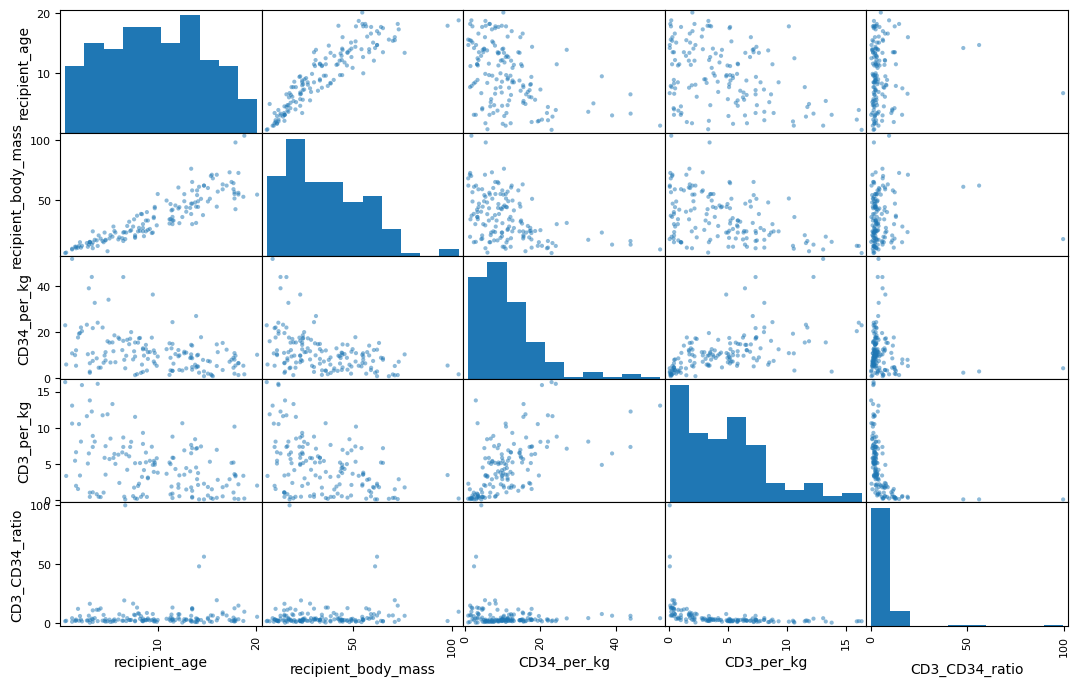

In [27]:
scatter_matrix(visualization_data[num_attribs], alpha=0.5, figsize=(13, 8))

In [28]:
data.groupby("recipient_gender")[["recipient_age", "recipient_body_mass"]].corr()

recipient_age  recipient_body_mass
recipient_gender                                                        
female           recipient_age             1.000000             0.883065
                 recipient_body_mass       0.883065             1.000000
male             recipient_age             1.000000             0.895447
                 recipient_body_mass       0.895447             1.000000

The pipeline

In [29]:
def encode_booleans(data: DataFrame):
    zero_mapper = {"absent", "no", "female", "mismatched", "female_to_male", "low", "nonmalignant", "peripheral_blood", "?"}
    one_mapper  = {"present", "yes", "male", "matched", "other", "high", "malignant", "bone_marrow"}

    def map_values(value):
        if value in zero_mapper:
            return 0
        if value in one_mapper:
            return 1
        
        return value

    return data.map(map_values)

In [30]:
class MissingAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: DataFrame):
        X = X.copy()
        X["donor_CMV_missing"] = (X["donor_CMV"] == "?").astype(int)
        X["recipient_CMV_missing"] = (X["recipient_CMV"] == "?").astype(int)

        X["ABO_match_missing"] = (X["ABO_match"] == "?").astype(int)
        return X

In [31]:
def impute_body_mass(data: DataFrame):
    data = data.copy()

    data["recipient_age_group"] = pd.cut(data["recipient_age"], bins=[0., 1., 5., 10., 15., 20., np.inf], labels=["<1", "1-5", "5-10", "10-15", "15-20", "20+"])

    group_median = data.groupby(["recipient_gender", "recipient_age_group"])["recipient_body_mass"].median()

    def fill_mass(row):
        if pd.isna(row["recipient_body_mass"]):
            return group_median.get((row["recipient_gender"], row["recipient_age_group"]), data["recipient_body_mass"].median())
        return row["recipient_body_mass"]

    data["recipient_body_mass"] = data.apply(fill_mass, axis=1)

    data = data.drop(columns="recipient_age_group")
    return data

In [32]:
model_data = df.dropna(subset=["CD3_per_kg", "CD34_per_kg"])
X = model_data[["CD34_per_kg", "recipient_body_mass"]]
y = model_data["CD3_per_kg"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)

score

0.35813140302200064

In [33]:
def impute_cell_dosage(data: DataFrame):
    data = data.copy()

    train_data = data.dropna(subset=["CD3_per_kg", "CD34_per_kg"])

    linear_reg = LinearRegression()
    linear_reg.fit(train_data[["CD34_per_kg", "recipient_body_mass"]], train_data["CD3_per_kg"])

    missing_CD3_data = data["CD3_per_kg"].isna()
    data.loc[missing_CD3_data, "CD3_per_kg"] = linear_reg.predict(data.loc[missing_CD3_data, ["CD34_per_kg", "recipient_body_mass"]])

    data.loc[data["CD3_CD34_ratio"].isna(), "CD3_CD34_ratio"] = data["CD3_per_kg"] / data["CD34_per_kg"]

    return data


In [34]:
bool_attribs = ["donor_age_below_35", "donor_CMV", "recipient_age_below_10", "recipient_CMV", "recipient_gender", "malignant_disease", "ABO_match",
                "gender_match", "HLA_match", "risk_group", "stem_cell_source", "transplant_repeat"]

nominal_attribs = ["donor_ABO", "recipient_ABO", "disease", "CMV_serostatus"]

ordinal_attribs = ["donor_age_group", "HLA_score"]

ordinal_cats = [["18-35", "35-50", "50-60"],
                ["7/10", "8/10", "9/10", "10/10"]]

num_attribs = ["donor_age", "recipient_age", "recipient_body_mass", "antigens_incompatible",
               "allels_incompatible", "CD34_per_kg", "CD3_per_kg", "CD3_CD34_ratio"]

In [35]:
num_imputing = Pipeline([
    ("body_mass_imputer", FunctionTransformer(impute_body_mass, validate=False)),
    ("cell_dosage_imputer", FunctionTransformer(impute_cell_dosage, validate=False)),
])

cat_encoding = ColumnTransformer([
    ("bool_encoder", FunctionTransformer(encode_booleans, validate=False), bool_attribs),
    ("nom_encoder", OneHotEncoder(), nominal_attribs),
    ("ord_encoder", OrdinalEncoder(categories=ordinal_cats), ordinal_attribs),
])

preprocessing = Pipeline([
    ("num_imputing", num_imputing),
    ("cat_encoding", cat_encoding),
    ("std_scaler", StandardScaler()),
])

data_prep_pipe = Pipeline([
    ("dupes_clean", FunctionTransformer(lambda data: data.drop_duplicates(), validate=False)),
    ("construct", MissingAttributesAdder()),
    ("preprocess", preprocessing),
])

# remove duplicates
# create missing CMV, ABO features
# encode cat
    # ordinal
    # nominal (1 hot)

# impute numerical
    # impute body mass based of age and gender
    # impute cell dosage based

data_prepared = data_prep_pipe.fit_transform(data)
# pd.DataFrame(pipeline_testdata)

C:\Users\rikis\AppData\Local\Temp\ipykernel_15928\3503495110.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_median = data.groupby(["recipient_gender", "recipient_age_group"])["recipient_body_mass"].median()


Dimensionality Reduction

In [36]:
pca = PCA(n_components=0.95)
data_reduced = pca.fit_transform(data_prepared)

## Model Testing

In [37]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [38]:
scoring = {
    "acc": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "roc_auc": "roc_auc"
}

In [39]:
log_reg = LogisticRegressionCV(class_weight="balanced", scoring="recall", max_iter=1000)

# scores = cross_validate(log_reg, data_reduced, data_label, cv=4, scoring=scoring)

# for metric in scoring:
#     print(metric, scores[f"test_{metric}"])

data_pred = cross_val_predict(log_reg, data_prepared, data_label, cv=4)
data_pred_prob = cross_val_predict(log_reg, data_prepared, data_label, cv=4, method="predict_proba") # for roc curve

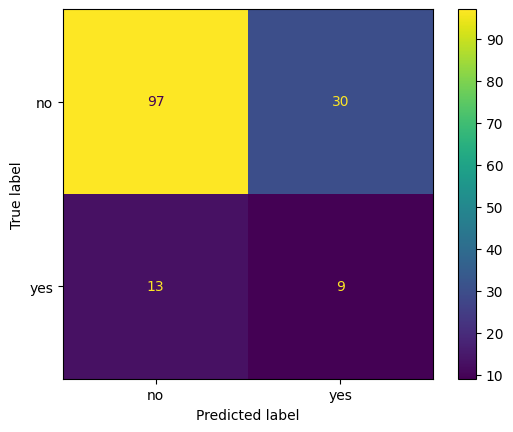

In [40]:
cmatrix = confusion_matrix(data_label, data_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=["no", "yes"])
disp.plot()
plt.show()

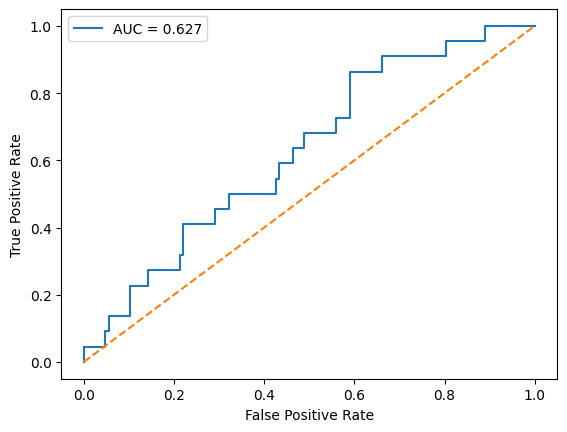

In [41]:
fpr, tpr, thresholds = roc_curve(data_label, data_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
kn = KNeighborsClassifier()

scores = cross_val_score(kn, data_reduced, data_label, cv=5, scoring="recall")

display_scores(scores)

Scores: [0. 0. 0. 0. 0.]
Mean: 0.0
Standard Deviation: 0.0


In [43]:
st_grad_desc = SGDClassifier(class_weight="balanced")

scores = cross_val_score(st_grad_desc, data_reduced, data_label, cv=5, scoring="recall")

display_scores(scores)

Scores: [0.5  0.5  0.4  0.4  0.75]
Mean: 0.51
Standard Deviation: 0.12806248474865697


In [44]:
randforest_reg = RandomForestClassifier(class_weight="balanced")

scores = cross_val_score(randforest_reg, data_reduced, data_label, cv=5, scoring="recall")

display_scores(scores)

Scores: [0. 0. 0. 0. 0.]
Mean: 0.0
Standard Deviation: 0.0
